### This jupyter notebooks provides the code for classifying signals using DCT and various DWTs, with various lengths of truncation.

In [1]:
import os
from time import perf_counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pywt
from collections import defaultdict, Counter
from scipy import signal as scipy_signal

import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from sklearn.metrics import confusion_matrix

import pdb
history = History()

# 1. Loading the UCI HAR dataset
Download the dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
activities_description = {
    0: 'walking',
    1: 'walking upstairs',
    2: 'walking downstairs',
    3: 'sitting',
    4: 'standing',
    5: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../datasets/UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


### Let's assess the signals' frequency/scale domain properties

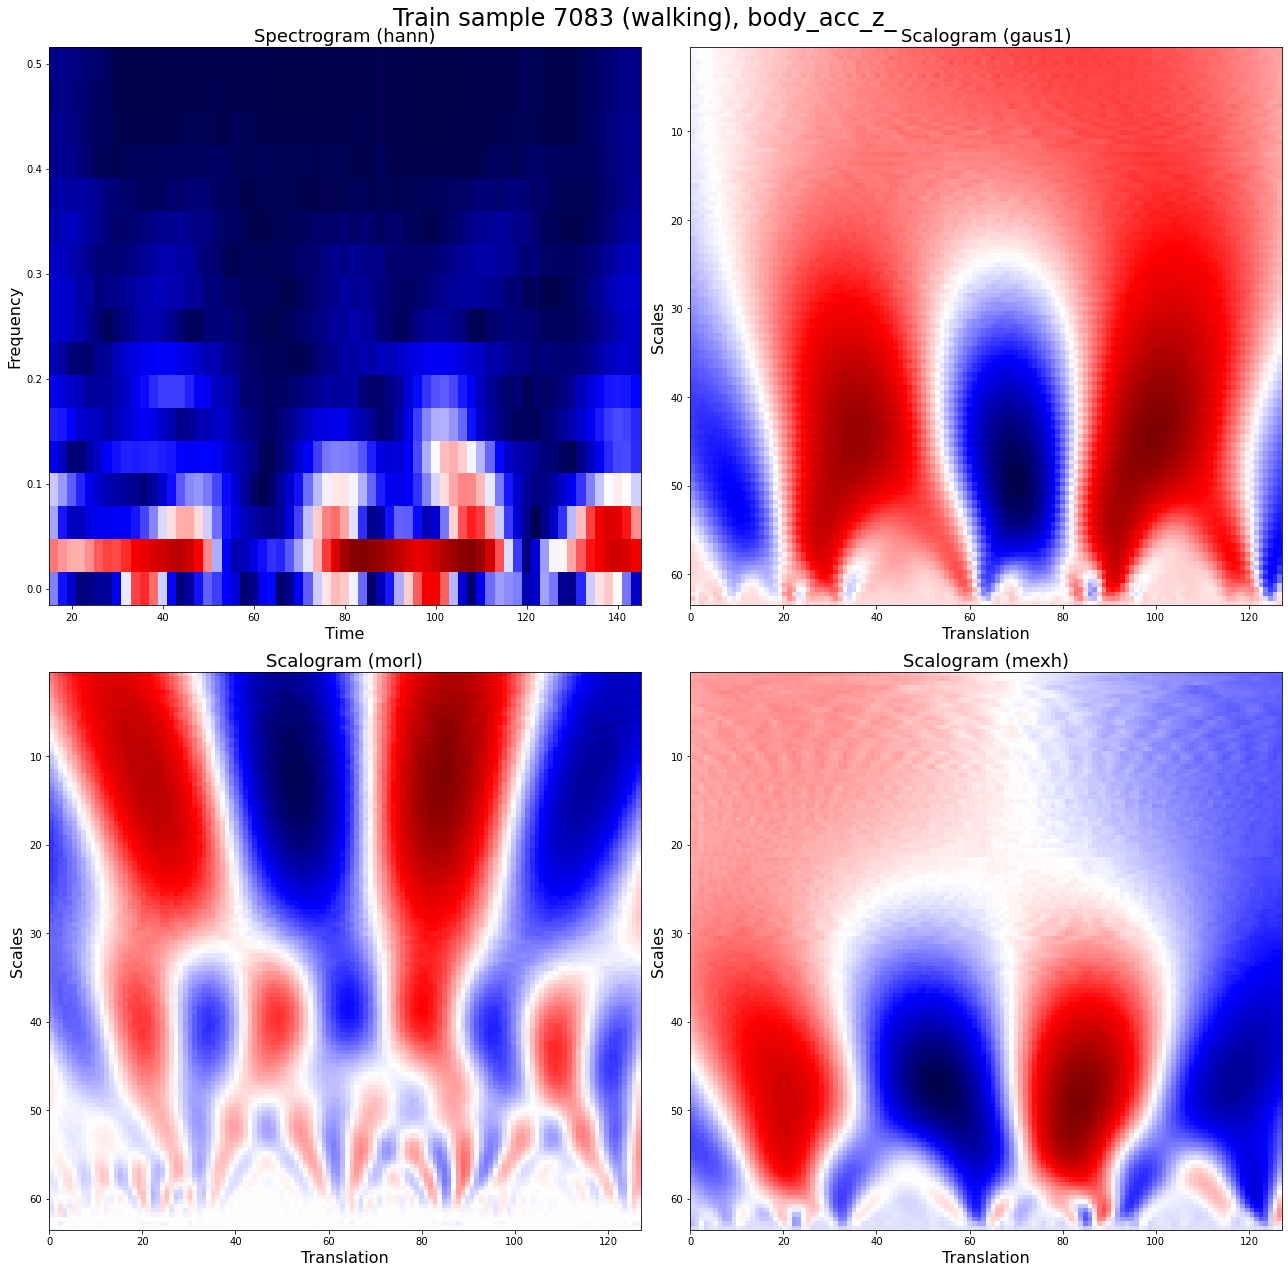

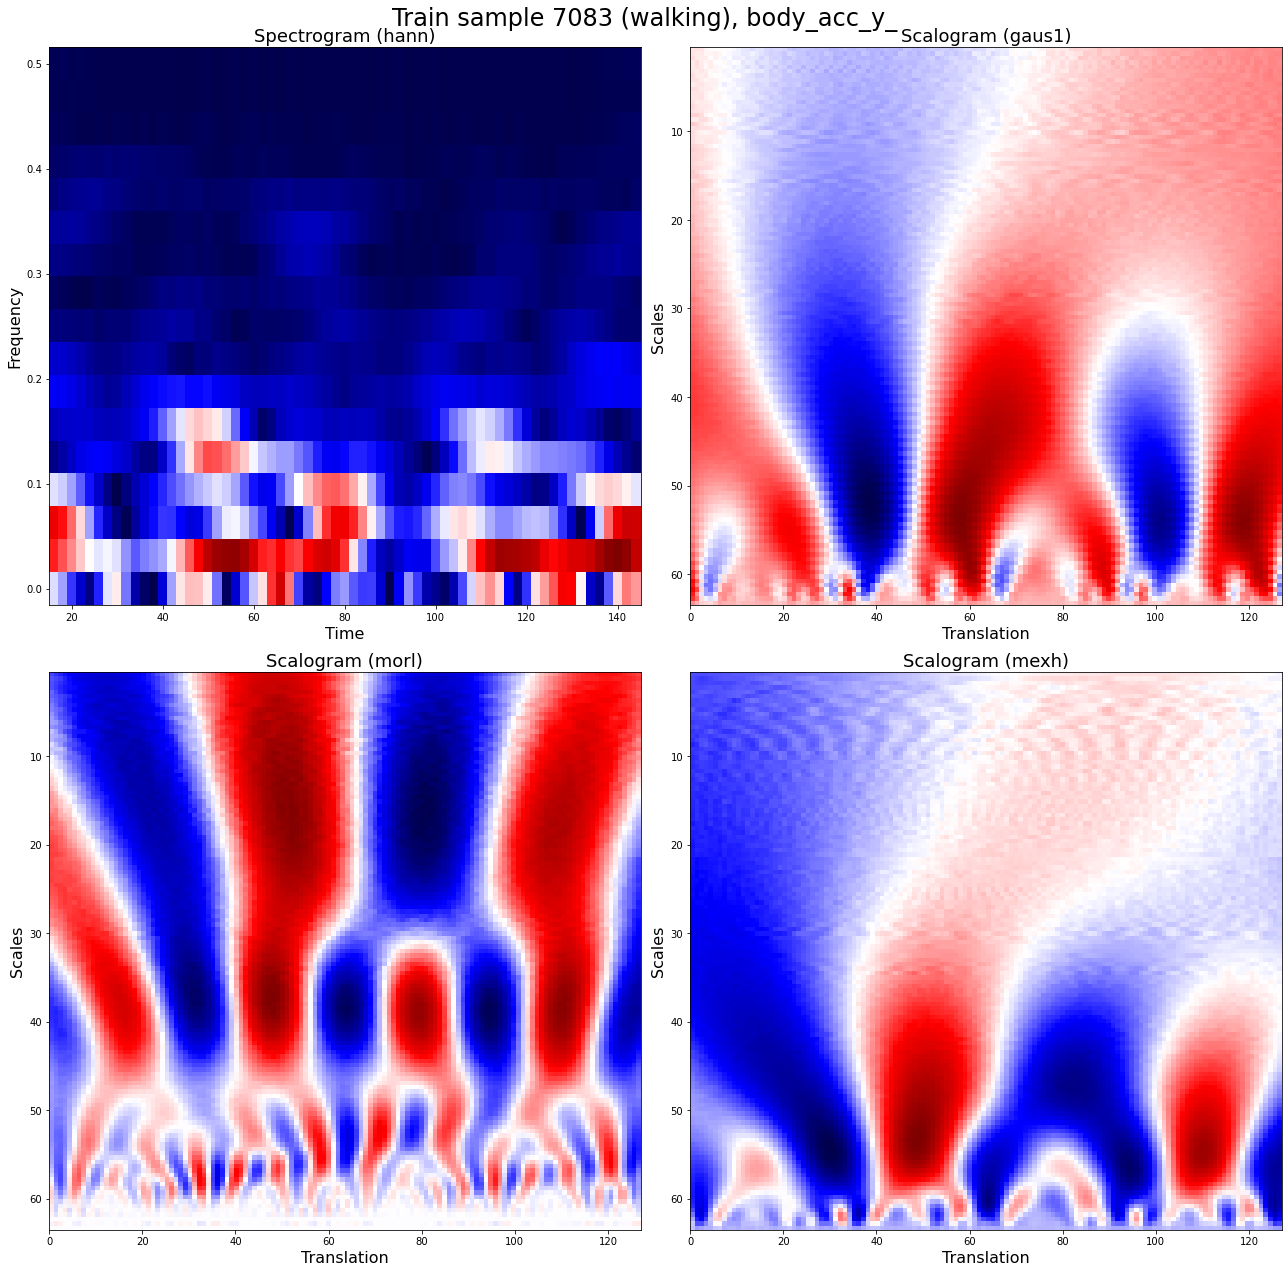

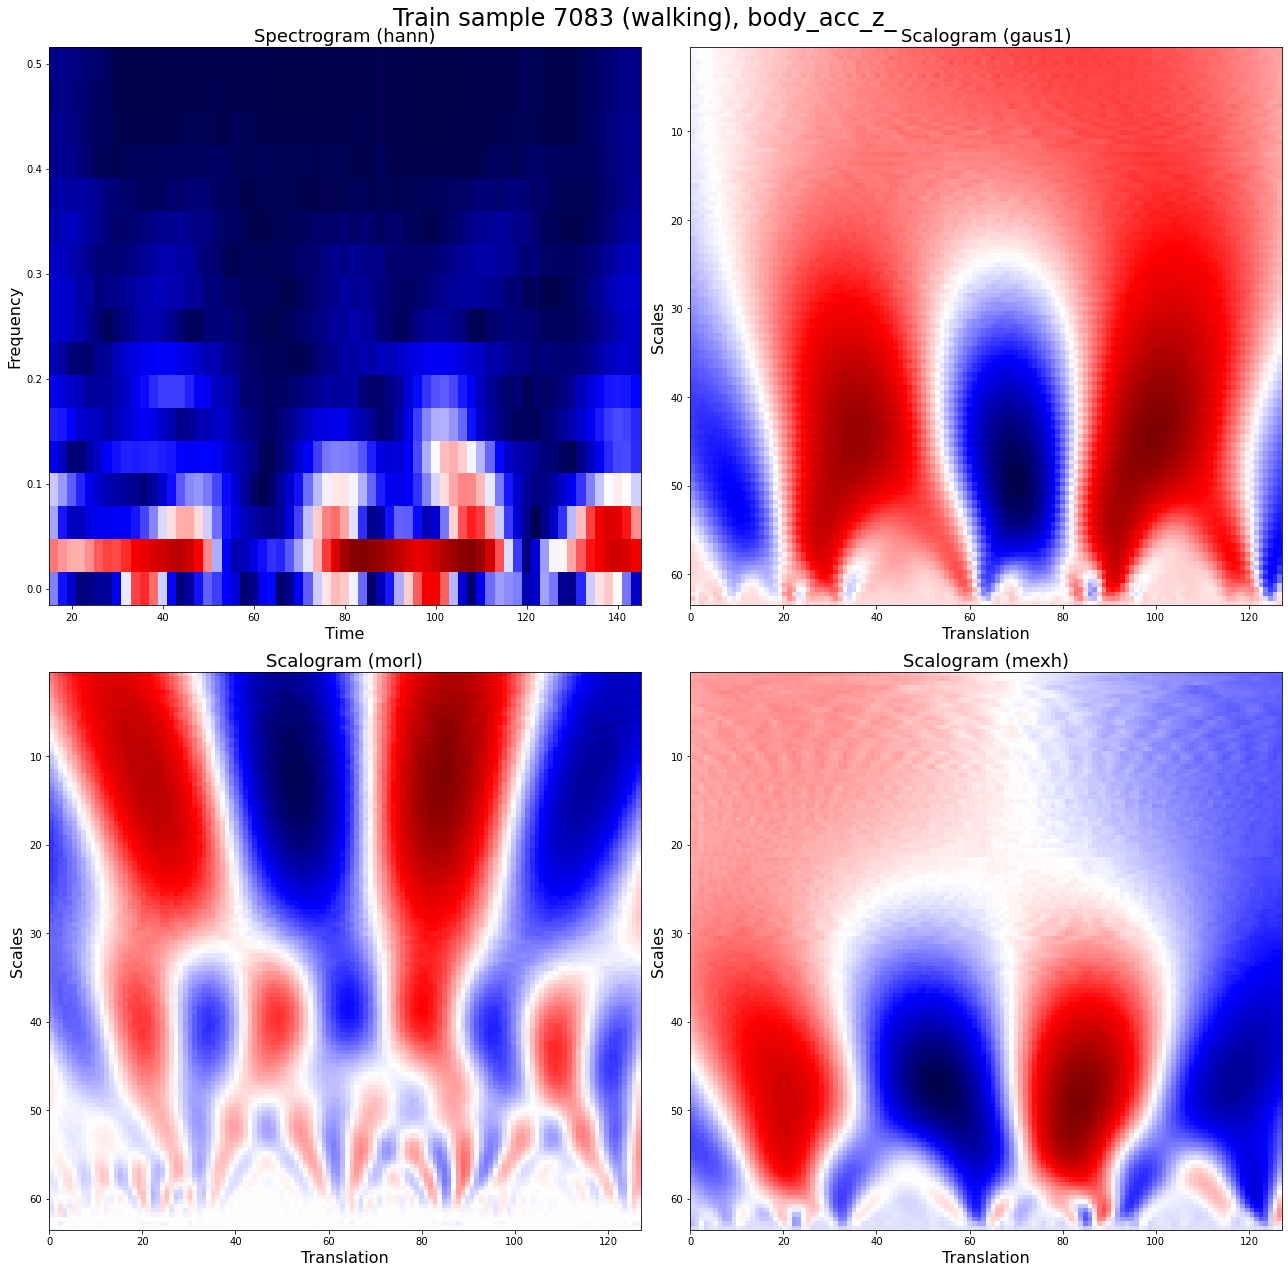

In [3]:
from numpy import log10, absolute as abs
from scipy.fftpack import dct,fft

def get_spectrogram(sig, M, noverlap, fs=1.0, windowname = ('hamming'), 
                     ax=None, cmap = plt.cm.seismic):
    # get the window taps
    win = scipy_signal.get_window(windowname,M,False)
    # prefix/suffix
    pref = sig[-int(M/2):]*win[0:int(M/2)]
    suf = sig[0:int(M/2)]*win[-int(M/2):]

    sig = np.concatenate((pref, sig))
    sig = np.concatenate((sig,suf))
    f, t, mag = scipy_signal.spectrogram(sig, fs, window=win, nperseg=M, noverlap=noverlap,
                                  scaling='spectrum', mode='magnitude')
    if ax:
        ax.pcolormesh(t, np.flip(f), np.flip(mag,axis=0), shading='nearest',cmap=cmap)
    return mag

def get_cwt(sig, wavelet, ax=None, cmap=plt.cm.seismic):
    voices_per_octave = 8
    max_scale = 8
    begin_scale = 1/(2**1)
    scales = list(range(1,int((max_scale/begin_scale)*voices_per_octave)))
    scales = [begin_scale*float(x) for x in scales]
    coef,f = pywt.cwt(sig,scales,wavelet)
    if ax:
        ax.matshow(np.flip(coef,axis=0), cmap=cmap, extent=[0,len(sig)-1,scales[-1],scales[0]], aspect='auto')
        ax.xaxis.set_ticks_position('bottom')
    return coef
    
# Randomly choose 10 signals from the training set
sample_set = np.random.randint(len(train_signals),size=1)
# Choose 3 random components to analyze
rand_comp = np.random.randint(9,size=3)

wavelets=['gaus1','morl','mexh']
#wavelets=['gaus1']

# Parameters for spectrogram
win = 'hann'
M = 32
noverlap = M-2

for i,sig in enumerate(train_signals[sample_set]):
    ## Now we plot
    for c in rand_comp:
        fig, ax = plt.subplots(figsize=(18,18), nrows=2,ncols=2)
        fig.suptitle('Train sample {} ({}), {}'.format(sample_set[i],
            activities_description[train_labels[sample_set[i]]],INPUT_FILES_TRAIN[c][:11]),
                     fontsize=24)

        ax[0][0].set_title('Spectrogram ({})'.format(win), fontsize=18)
        get_spectrogram(sig[:,c], M, noverlap, ax=ax[0][0])
        ax[0][0].set_ylabel('Frequency', fontsize=16)
        ax[0][0].set_xlabel('Time', fontsize=16)

        curr_ax=1
        for w in wavelets:
            px,py = int(curr_ax/2), curr_ax-(2*int(curr_ax/2))
            get_cwt(sig[:,c], w, ax=ax[px][py])
            curr_ax += 1
            ax[px][py].set_title('Scalogram ({})'.format(w), fontsize=18)
            ax[px][py].set_ylabel('Scales', fontsize=16)
            ax[px][py].set_xlabel('Translation', fontsize=16)

        fig.tight_layout()


### Here we define the neural networks that we intend to use for classification

In [4]:
# NN: Classifier for 2D inputs for UCI HAR
def NN (x_train, y_train, x_test, y_test, print_nn=False, verbosity=0):

    num_classes = 6

    batch_size = 16
    epochs = 32

    input_shape = np.shape(x_train)[1:]

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # convert class vectors to binary class matrices - this is for use in the
    # categorical_crossentropy loss below
    y_train = list(y_train)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = list(y_test)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dropout(0.2, input_shape=input_shape)) 
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2)) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    if print_nn:
        model.summary()
        return
    
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=4)
    t_start = perf_counter()
    model.fit(x_train, y_train, batch_size=batch_size, 
              epochs=epochs, verbose=verbosity, 
              validation_data=(x_test, y_test), 
              callbacks=[history,es])
    t_stop = perf_counter()
    t_diff = t_stop-t_start

    #train_score = model.evaluate(x_train, y_train, verbose=0)
    test_score = model.evaluate(x_test, y_test, verbose=0)

    return test_score[0], test_score[1], t_diff, model


### Generating the UCI-HAR features from DCT or DWT

In [5]:
# Courtesy https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    f = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.show()


In [6]:
def get_uci_har_cwt_features(dataset, labels, waveletname):
    data_shape = np.shape(dataset)
    data_len = data_shape[0]
    
    # Now determine output shape to preallocate array for speed
    coeff = get_cwt(dataset[0, :, 0], waveletname)
    op_shape=[data_len]
    op_shape.extend(list(np.shape(coeff)))
    op_shape.append(data_shape[-1])
    data_cwt = np.ndarray(shape=op_shape)

    for ii in range(0,data_len):
        if ii % 1000 == 0:
            print(ii)
        for jj in range(0,data_shape[-1]):
            sig = dataset[ii, :, jj]
            coeff = get_cwt(sig, waveletname)
            #coeff_ = coeff[:,:127]
            data_cwt[ii, :, :, jj] = coeff

    X = np.array(data_cwt)
    Y = labels
    return X, Y

def get_uci_har_stft_features(dataset, labels, M, noverlap, win):
    data_shape = np.shape(dataset)
    data_len = data_shape[0]

    # Now determine output shape to preallocate array for speed
    coeff = get_spectrogram(dataset[0, :, 0], M, noverlap, windowname = win)
    op_shape=[data_len]
    op_shape.extend(list(np.shape(coeff)))
    op_shape.append(data_shape[-1])
    data_stft = np.ndarray(shape=op_shape)

    for ii in range(0,data_len):
        if ii % 1000 == 0:
            print(ii)
        for jj in range(0,data_shape[-1]):
            sig = dataset[ii, :, jj]
            coeff = get_spectrogram(sig, M, noverlap, windowname = win)
            #coeff_ = coeff[:,:127]
            #import pdb; pdb.set_trace()
            data_stft[ii, :, :, jj] = coeff

    X = np.array(data_stft)
    Y = labels
    return X, Y

### Now we run the classifiers in a loop of different truncation lengths of the input features

In [ ]:
import matplotlib.gridspec as gridspec

labels_arr=list(activities_description[k] for k in activities_description.keys())

fig_perf = plt.figure(figsize=(36,14))
spec = gridspec.GridSpec(ncols=2, nrows=1)
perf_left_ax = fig_perf.add_subplot(spec[0,0])
perf_right_ax = fig_perf.add_subplot(spec[0,1])
perf_left_ax.set_title('Accuracy',fontsize=26)
perf_right_ax.set_title('Loss',fontsize=26)

# for testing
num_train=None
num_test=None

# STFT first
x_train, y_train = get_uci_har_stft_features(uci_har_signals_train[:num_train,:,:], 
                                             uci_har_labels_train[:num_train], M, noverlap, win)
x_test, y_test = get_uci_har_stft_features(uci_har_signals_test[:num_test,:,:], 
                                           uci_har_labels_test[:num_test], M, noverlap, win)
val_loss, val_acc, train_time, mdl = NN(x_train, y_train, x_test, y_test)

y_pred = np.argmax(mdl.predict(x_test),axis=1)
cm = confusion_matrix(y_test,y_pred,labels=range(no_labels))
plot_confusion_matrix(cm,labels_arr,title='Spectrogram')
    
plt.figure(fig_perf.number)
perf_left_ax.plot(history.history['val_accuracy'], label='stft')
perf_right_ax.plot(history.history['val_loss'], label='stft')

# CWTs next
#wavelets=['gaus1']
for w in wavelets:
    x_train, y_train = get_uci_har_cwt_features(uci_har_signals_train[:num_train,:,:],
                                                uci_har_labels_train[:num_train], w)
    x_test, y_test = get_uci_har_cwt_features(uci_har_signals_test[:num_test,:,:], 
                                              uci_har_labels_test[:num_test], w)
    val_loss, val_acc, train_time, mdl = NN(x_train, y_train, x_test, y_test)

    y_pred = np.argmax(mdl.predict(x_test),axis=1)
    cm = confusion_matrix(y_test,y_pred,labels=range(no_labels))
    plot_confusion_matrix(cm,labels_arr,title='CWT {}'.format(w))

    plt.figure(fig_perf.number)
    perf_left_ax.plot(history.history['val_accuracy'], label='cwt-{}'.format(w))
    perf_right_ax.plot(history.history['val_loss'], label='cwt-{}'.format(w))

plt.figure(fig_perf.number)
perf_left_ax.set_ylabel('Accuracy', fontsize=22)
perf_right_ax.set_ylabel('Loss', fontsize=22)
perf_left_ax.set_xlabel('Epoch', fontsize=22)
perf_right_ax.set_xlabel('Epoch', fontsize=22)
perf_left_ax.legend(fontsize=18)
perf_right_ax.legend(fontsize=18)

plt.legend()

plt.show()


0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
0
1000
2000
3000
4000
5000
6000
7000


In [ ]:
print(pywt.wavelist(kind='continuous'))